# Dioptra Example
### Predictive Modeling Entrypoint(s)
Demo to be instantiated within Dioptra once artifact functionality comes online. For now, we demonstrate plugins in this jupyter notebook

### Plugins Developed 
see `plugins.py`
1. Load Dataset
2. Transform variables/ create features
3. Split dataset into train/test
4. Fit models
5. Evaluate models (on train and test)

### Example usage:

1. Set entrypoint parameters (demarcated by all caps variables)
2. Run plugins as python functions to simulate entrypoint usage
    1. Read in dataset from path (first, download if needed via helper functions)
    2. Transformations implemented: normalize some variables (subtract mean, divide by std dev)
    3. Split transformed dataset into train/test splits
    4. Train models on training dataset 
        - Models available:
            - For regression: linear regression, KNN regression, DT regression, Adaboost
            - For classification: logistic regression, KNN classification, DT classification, Adaboost
            - "Naive model" - predicts mean (regression) or random (classification) for benchmarking
    5. Evaluate model for predictive power:
        - metrics considered: Mean Squared Error (MSE) or Accuraccy
    6. Evaluate model for Bias 
        - metrics considered: depends on problem, but look at group fairness ratios (i.e. false positive rate ratio)
 3. Inspect and Visualize some output from the entrypoint (could be moved into a plugin eventually) 

### [Set Up] Import modules

In [ ]:
import predictive_model_plugins.plugins as plugins
from get_datasets import  get_compas_dataset, get_income_dataset
from aif360.explainers import MetricJSONExplainer
import json

import pandas as pd
import matplotlib.pyplot as plt

from IPython.display import Markdown, display

### [Set Up] Choose prediction scenario
Choice determines parameters and type of prediction problem

In [87]:
prediction_problem_type = 'prison_recidivism' # options: 'census_income' or 'prison_recidivism'

## _Entrypoint Parameters_

In [ ]:
if prediction_problem_type == 'census_income':
    
    problem_statement = ('- Using Census data, classify individuals income levels as either below $50K (label=1) or above $50K (label=0)' +
                         '\n\n- For bias auditing purposes, assume the individuals classified as below $50K (label=1) will recieve' +
                         ' social assistance services (assistive outreach for positive predictions)'+
                         '\n\n- Protected attribute: Race (a binary variable where 1=White and 0=Non-white)' 
                        )
    
    DATA_PATH = 'data/census_data.csv'
    DF, DF_META_INFO = get_income_dataset()
    DF = pd.read_csv(DATA_PATH)
    DEP_VAR = 'income_below_50K'
    PROTECT_GROUP_VAR = 'race'
    LABEL_NAMES = ["Not Below $50K", "Below $50K" ]
    INDEP_VARS = [col for col in DF.columns if (
                                (col!=DEP_VAR)
                                and ('marital-status' not in col) 
                                and ('relationship' not in col)
                                and ('native-country' not in col)
                                and ('education=' not in col))]
    

    NORMALIZE_VARS = ['age', 'education-num', 'capital-gain' ,'capital-loss', 'hours-per-week']
    EVALUATION_METRICS =[ {'metric_name':'accuracy', 
                        'metric_label':'Accuracy',
                        'metric_kwargs':{}},
                      
                       {'metric_name':'classification_bias',
                        'metric_label':'FNR Ratio',
                        'metric_kwargs': {'bias_metric': 'false_negative_rate_ratio',
                                         'protected_attribute_names':'race',
                                         'privileged_groups': [{'race':1}],
                                          'unprivileged_groups':[ {'race':0}] }
                                            }
                        ]
    
elif prediction_problem_type == 'prison_recidivism':

    problem_statement = ('Using Defendant Data from Compas Propublica investigation, classify defendant as likely to recidivate' +
                         ' within two years (label=1) or unlikely to recidivate (label=0)' +
                         '\n\n- For bias auditing purposes, assume the individuals classified as higher risk will be punished' +
                         ' with stricter sentencing/bail actions (punitive action for positive label)' +
                         '\n\n- Protected attribute: Race (a binary variable where 1=White and 0=Non-white)'
                        )
    
    DATA_PATH = 'data/compas_data.csv'
    DF, DF_META_INFO = get_compas_dataset()
    DEP_VAR = 'two_year_recid'
    LABEL_NAMES = ["Didn't Recidivate", "Recidivated" ]
    PROTECT_GROUP_VAR = 'race'
    INDEP_VARS = [col for col in DF.columns if (
                                (col!=DEP_VAR)
                                and ('c_charge_desc' not in col) 
                                                 )]
    NORMALIZE_VARS = ['age', 'juv_fel_count', 'juv_misd_count',	'juv_other_count', 'priors_count' ]
    PROTECT_GROUP_VAR = DF_META_INFO['protected_attribute_names'][1]
    PROTECT_GROUP_VAR = 'race'
    EVALUATION_METRICS =[ {'metric_name':'accuracy', 
                        'metric_label':'Accuracy',
                        'metric_kwargs':{}},
                      
                       {'metric_name':'classification_bias',
                        'metric_label':'FPR Ratio',
                        'metric_kwargs': {'bias_metric': 'false_positive_rate_ratio',
                                         'protected_attribute_names':'race',
                                         'privileged_groups': [{'race':1}],
                                          'unprivileged_groups':[ {'race':0}] }
                                            }
                        ]

# Common parameters regardless of problem 

FILETYPE = 'csv'
TRANSFORMATIONS = [ ('normalize', [NORMALIZE_VARS], {'drop_original':True})] # (function, positional args, kwargs)

INDEP_VARS_TRANSFORMED = [var + '_norm' if var in NORMALIZE_VARS else var for var in INDEP_VARS]
MODEL_TYPE = 'classification'

MODEL1_CLASS = 'LogisticClassifier'
MODEL1_HYPERPARAMETERS = {'penalty':'l2'}

MODEL2_CLASS = 'DecisionTreeModel'
MODEL2_HYPERPARAMETERS = {'criterion':'gini',
                                   'min_samples_split': 10
                                    ,'max_depth' : 4
                                    }

# MODEL3_CLASS = 'KNNModel'
# MODEL3_HYPERPARAMETERS = {'n_neighbors':50, 'weights':'uniform'}

MODEL3_CLASS = 'AdaBoostModel'
MODEL3_HYPERPARAMETERS = {}



## Print Summary of Entrypoint Run

In [89]:
def print_markdown(txt):
    display(Markdown(txt))

txt = f"""

_Automatically Printed Description_

--- 

# Prediction Problem Overview: `{prediction_problem_type}`

{problem_statement}

Data is stored at `{DATA_PATH}`

## Modeling Parameters:
- Dependant Variable/Target: `{DEP_VAR}`
- Protected Attribute: `{PROTECT_GROUP_VAR}`

### Predictors ({len(INDEP_VARS)} total predictors) 

{''.join([ f'_{var}_; ' for var in INDEP_VARS]) }

## Models:
---

#### Model 1: `{MODEL1_CLASS}`
params: `{MODEL1_HYPERPARAMETERS}`

#### Model 2: `{MODEL2_CLASS}`
params: `{MODEL2_HYPERPARAMETERS}`

#### Model 3: `{MODEL3_CLASS}`
params: `{MODEL3_HYPERPARAMETERS}`

#### **Naive Model**:
_Always predicts mean y value (regression) or random classification (classification)_

## Evaluation Criteria:
---

#### Peformance: `{EVALUATION_METRICS[0]['metric_label']}`
`{EVALUATION_METRICS[0]['metric_kwargs']}`

#### Bias: `{EVALUATION_METRICS[1]['metric_label']}`
`{EVALUATION_METRICS[1]['metric_kwargs']}`

## Dataset Info:
---

#### Number of rows: `{DF.shape[0]}`

#### Description of dependant var:`{DEP_VAR}`
`{DF[DEP_VAR].describe()}`

---

"""
print_markdown(txt)



_Automatically Printed Description_

--- 

# Prediction Problem Overview: `prison_recidivism`

Using Defendant Data from Compas Propublica investigation, classify defendant as likely to recidivate within two years (label=1) or unlikely to recidivate (label=0)

- For bias auditing purposes, assume the individuals classified as higher risk will be punished with stricter sentencing/bail actions (punitive action for positive label)

- Protected attribute: Race (a binary variable where 1=White and 0=Non-white)

Data is stored at `data/compas_data.csv`

## Modeling Parameters:
- Dependant Variable/Target: `two_year_recid`
- Protected Attribute: `race`

### Predictors (12 total predictors) 

_sex_; _age_; _race_; _juv_fel_count_; _juv_misd_count_; _juv_other_count_; _priors_count_; _age_cat=25 - 45_; _age_cat=Greater than 45_; _age_cat=Less than 25_; _c_charge_degree=F_; _c_charge_degree=M_; 

## Models:
---

#### Model 1: `LogisticClassifier`
params: `{'penalty': 'l2'}`

#### Model 2: `DecisionTreeModel`
params: `{'criterion': 'gini', 'min_samples_split': 10, 'max_depth': 4}`

#### Model 3: `AdaBoostModel`
params: `{}`

#### **Naive Model**:
_Always predicts mean y value (regression) or random classification (classification)_

## Evaluation Criteria:
---

#### Peformance: `Accuracy`
`{}`

#### Bias: `FPR Ratio`
`{'bias_metric': 'false_positive_rate_ratio', 'protected_attribute_names': 'race', 'privileged_groups': [{'race': 1}], 'unprivileged_groups': [{'race': 0}]}`

## Dataset Info:
---

#### Number of rows: `6167`

#### Description of dependant var:`two_year_recid`
`count    6167.000000
mean        0.455489
std         0.498055
min         0.000000
25%         0.000000
50%         0.000000
75%         1.000000
max         1.000000
Name: two_year_recid, dtype: float64`

---



### _Dioptra Entrypoint Example Usage_


# Run Entrypoint / Task Graph

### 1. Load Dataset

In [90]:
DF = plugins.load_dataset(DATA_PATH, FILETYPE)
DF.head()

,sex,age,race,juv_fel_count,juv_misd_count,juv_other_count,priors_count,age_cat=25 - 45,age_cat=Greater than 45,age_cat=Less than 25,...,c_charge_desc=Viol Injunct Domestic Violence,c_charge_desc=Viol Injunction Protect Dom Vi,c_charge_desc=Viol Pretrial Release Dom Viol,c_charge_desc=Viol Prot Injunc Repeat Viol,c_charge_desc=Violation License Restrictions,c_charge_desc=Violation Of Boater Safety Id,c_charge_desc=Violation of Injunction Order/Stalking/Cyberstalking,c_charge_desc=Voyeurism,c_charge_desc=arrest case no charge,two_year_recid
0,0.0,69.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,34.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,0.0,24.0,0.0,0.0,0.0,1.0,4.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,0.0,44.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,41.0,1.0,0.0,0.0,0.0,14.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


### 2. Transform columns / create features

In [91]:
DF_FEATURES = plugins.create_features(DF, TRANSFORMATIONS )
DF_FEATURES.head()

,sex,race,age_cat=25 - 45,age_cat=Greater than 45,age_cat=Less than 25,c_charge_degree=F,c_charge_degree=M,c_charge_desc=Abuse Without Great Harm,c_charge_desc=Agg Abuse Elderlly/Disabled Adult,c_charge_desc=Agg Assault W/int Com Fel Dome,...,c_charge_desc=Violation Of Boater Safety Id,c_charge_desc=Violation of Injunction Order/Stalking/Cyberstalking,c_charge_desc=Voyeurism,c_charge_desc=arrest case no charge,two_year_recid,age_norm,juv_fel_count_norm,juv_misd_count_norm,juv_other_count_norm,priors_count_norm
0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,2.939421,-0.127658,-0.183293,-0.235184,-0.684347
1,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,-0.045357,-0.127658,-0.183293,-0.235184,-0.684347
2,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,-0.898151,-0.127658,-0.183293,1.888358,0.158589
3,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.807437,-0.127658,-0.183293,-0.235184,-0.684347
4,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.551599,-0.127658,-0.183293,-0.235184,2.265928


### 3. Split dataset into train/test

In [92]:
SPLITS = plugins.make_data_splits(DF_FEATURES)
DF_TRAIN, DF_TEST = (SPLITS['train']['df'], SPLITS['test']['df'] )

### 4. Train predictive models

In [93]:
MODEL_1 = plugins.train_predictive_model(MODEL1_CLASS, DF_TRAIN,  DEP_VAR, INDEP_VARS_TRANSFORMED, MODEL_TYPE, MODEL1_HYPERPARAMETERS )
MODEL_2 = plugins.train_predictive_model(MODEL2_CLASS, DF_TRAIN,  DEP_VAR, INDEP_VARS_TRANSFORMED, MODEL_TYPE, MODEL2_HYPERPARAMETERS )
MODEL_3 = plugins.train_predictive_model(MODEL3_CLASS, DF_TRAIN,  DEP_VAR, INDEP_VARS_TRANSFORMED, MODEL_TYPE, MODEL3_HYPERPARAMETERS )
NAIVE_MODEL = plugins.train_predictive_model('NaiveRegressor', DF_TRAIN,  DEP_VAR, INDEP_VARS_TRANSFORMED, MODEL_TYPE, {})

/home/cgl4/WSL_NIST/dioptra/dioptra_deployments/venv-deploy/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


### 5. Evaluate models

In [94]:
METRIC_OUTPUTS = []


for model in [MODEL_1, MODEL_2, MODEL_3, NAIVE_MODEL]:
    print('\n', type(model).__name__, ":", '\n', '-'*40, sep='')
    for metric_dict in EVALUATION_METRICS:
        metric_name = metric_dict['metric_name']
        metric_label = metric_dict['metric_label']
        metric_kwargs = metric_dict['metric_kwargs']

        
        for dataset_name, dataset in {'train':DF_TRAIN, 'test':DF_TEST}.items():
            #print(f"Evaluating {metric_name} for {dataset_name} and model {type(model).__name__}")
            row =  {'metric_name':metric_name, 'metric_label':metric_label, 'model':type(model).__name__, 'dataset_name':dataset_name}
            out = plugins.evaluate_model(model, dataset, metric_name, DEP_VAR, INDEP_VARS_TRANSFORMED, **metric_kwargs)[metric_name]
            row['metric_output'] = out
            row['metric_value'] = out['metric_value']
            print(f"{dataset_name} {out['metric_name']}: {round(out['metric_value'], 4)}")

            METRIC_OUTPUTS.append(row)



LogisticClassifier:
----------------------------------------
train Accuracy: 0.6789
test Accuracy: 0.6926
train false_positive_rate_ratio: 1.6254
test false_positive_rate_ratio: 2.2537

DecisionTreeModel:
----------------------------------------
train Accuracy: 0.683
test Accuracy: 0.6748
train false_positive_rate_ratio: 1.6482
test false_positive_rate_ratio: 2.0723

AdaBoostModel:
----------------------------------------
train Accuracy: 0.6823
test Accuracy: 0.6796
train false_positive_rate_ratio: 1.374
test false_positive_rate_ratio: 1.5673

NaiveModel:
----------------------------------------
train Accuracy: 0.4971
test Accuracy: 0.4826
train false_positive_rate_ratio: 1.0263
test false_positive_rate_ratio: 0.8464


# Show Evaluation Results

### Plot predictive power of models

First: isolate metrics and put into df for plotting

In [96]:
temp = pd.DataFrame(METRIC_OUTPUTS)
temp.drop('metric_output', axis=1, inplace=True)
temp['metric_id'] =  temp['metric_label'] + "_"  +temp['dataset_name'] 
metrics_df = temp.pivot_table(
    index=['model'],
    columns='metric_id',
    values='metric_value'
).reset_index()
metrics_df.reset_index()
metrics_df.columns.name=None
metrics_df

,model,Accuracy_test,Accuracy_train,FPR Ratio_test,FPR Ratio_train
0,AdaBoostModel,0.679643,0.682343,1.567256,1.373979
1,DecisionTreeModel,0.674777,0.682952,2.072261,1.648167
2,LogisticClassifier,0.692620,0.678897,2.253703,1.625397
3,NaiveModel,0.482563,0.497061,0.846447,1.026289


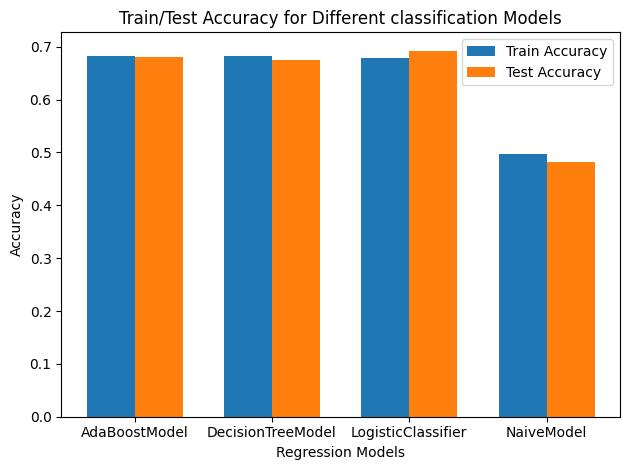

In [97]:
fix, ax = plt.subplots()

x = range(len(metrics_df))
width = .35

metric = EVALUATION_METRICS[0]['metric_label']

ax.bar(x, metrics_df[f'{metric}_train'], width, label=f'Train {metric}')
ax.bar([i + width for i in x], metrics_df[f'{metric}_test'], width, label=f'Test {metric}')

ax.set_xlabel('Regression Models')
ax.set_ylabel(metric.title())
ax.set_title(f"Train/Test {metric} for Different {MODEL_TYPE} Models")
ax.set_xticks([i+width / 2 for i in x])
ax.set_xticklabels(metrics_df['model'])

ax.legend()

plt.tight_layout()

### Print Bias Results

In [98]:
bias_metric_name = [ d['metric_kwargs']['bias_metric'] for d in EVALUATION_METRICS if d['metric_name'] == 'classification_bias' ]
bias_metric_outputs = [ d['metric_output'] for d in METRIC_OUTPUTS if d['metric_output']['metric_name'] == bias_metric_name[0] ] 

for i, (model, bias_metric_output) in enumerate(zip([MODEL_1, MODEL_2, MODEL_3, NAIVE_MODEL], bias_metric_outputs)):
    print('\n', type(model).__name__, ":", '\n', '-'*40, sep='')
    print(json.dumps(bias_metric_output, indent=4))


LogisticClassifier:
----------------------------------------
{
    "metric_name": "false_positive_rate_ratio",
    "metric_description": {
        "metric": "False Positive Rate Ratio",
        "message": "False positive rate ratio (false positive rate on unprivileged instances / false positive rate on privileged instances): 1.6253968253968254",
        "numFalsePositivesUnprivileged": 440.0,
        "numNegativesUnprivileged": 1650.0,
        "numFalsePositivesPrivileged": 168.0,
        "numNegativesPrivileged": 1024.0,
        "description": "False positive rate is computed as (false positive count / total negative count). This metric is computed as the ratio of false positive rates between the unprivileged and privileged groups",
        "ideal": "The ideal value of this metric is 1.0"
    },
    "metric_value": 1.6253968253968254
}

DecisionTreeModel:
----------------------------------------
{
    "metric_name": "false_positive_rate_ratio",
    "metric_description": {
        "me

### Plot Predictive power vs Bias

Text(0.5, 1.0, 'Accuracy vs Bias (FPR Ratio) tradeoff for ML Models')

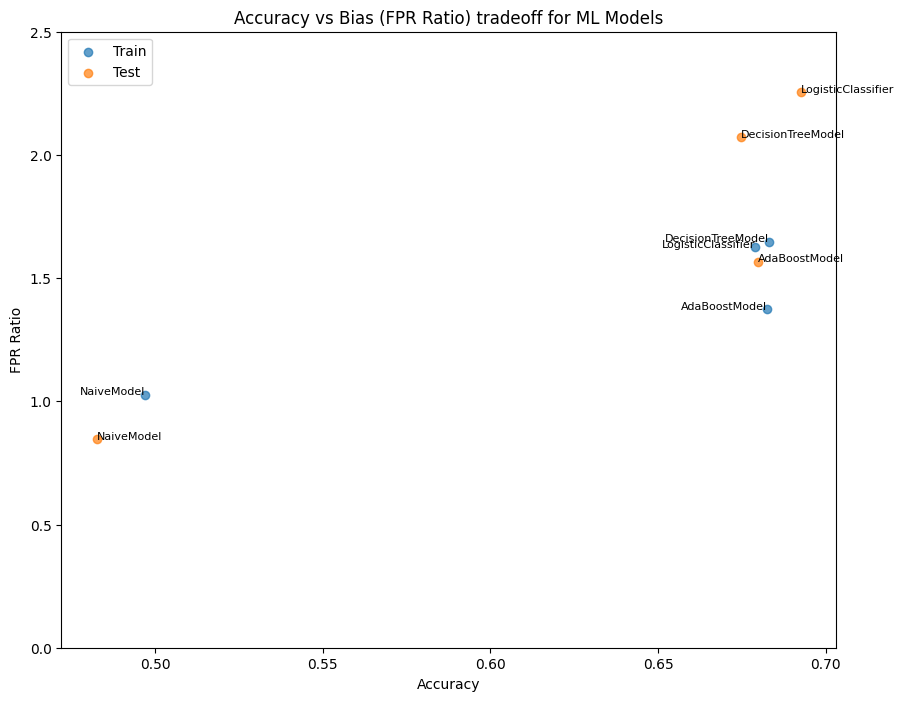

In [99]:
metric_1 = EVALUATION_METRICS[0]['metric_label']
metric_2 = EVALUATION_METRICS[1]['metric_label']

x1, y1 = (metrics_df[f'{metric_1}_train'], metrics_df[f'{metric_2}_train'])
x2,y2 = (metrics_df[f'{metric_1}_test'], metrics_df[f'{metric_2}_test'])

plt.figure(figsize=(10,8))

plt.scatter( x1, y1, label='Train', alpha =.7)
plt.scatter( x2, y2, label='Test', alpha =.7)

for i, label in enumerate(metrics_df['model']):
    plt.text(x1[i],y1[i], label, fontsize=8, ha='right')
    plt.text(x2[i],y2[i], label, fontsize=8, ha='left')

plt.legend()

plt.xlabel(metric_1)
#plt.xlim( (0.45,.8))

plt.ylabel(metric_2)
plt.ylim(0,2.5)

plt.title(f"{metric_1} vs Bias ({metric_2}) tradeoff for ML Models")

---

## _Exploratory work: feature importance on models_


#### Decision Path for Decision Tree

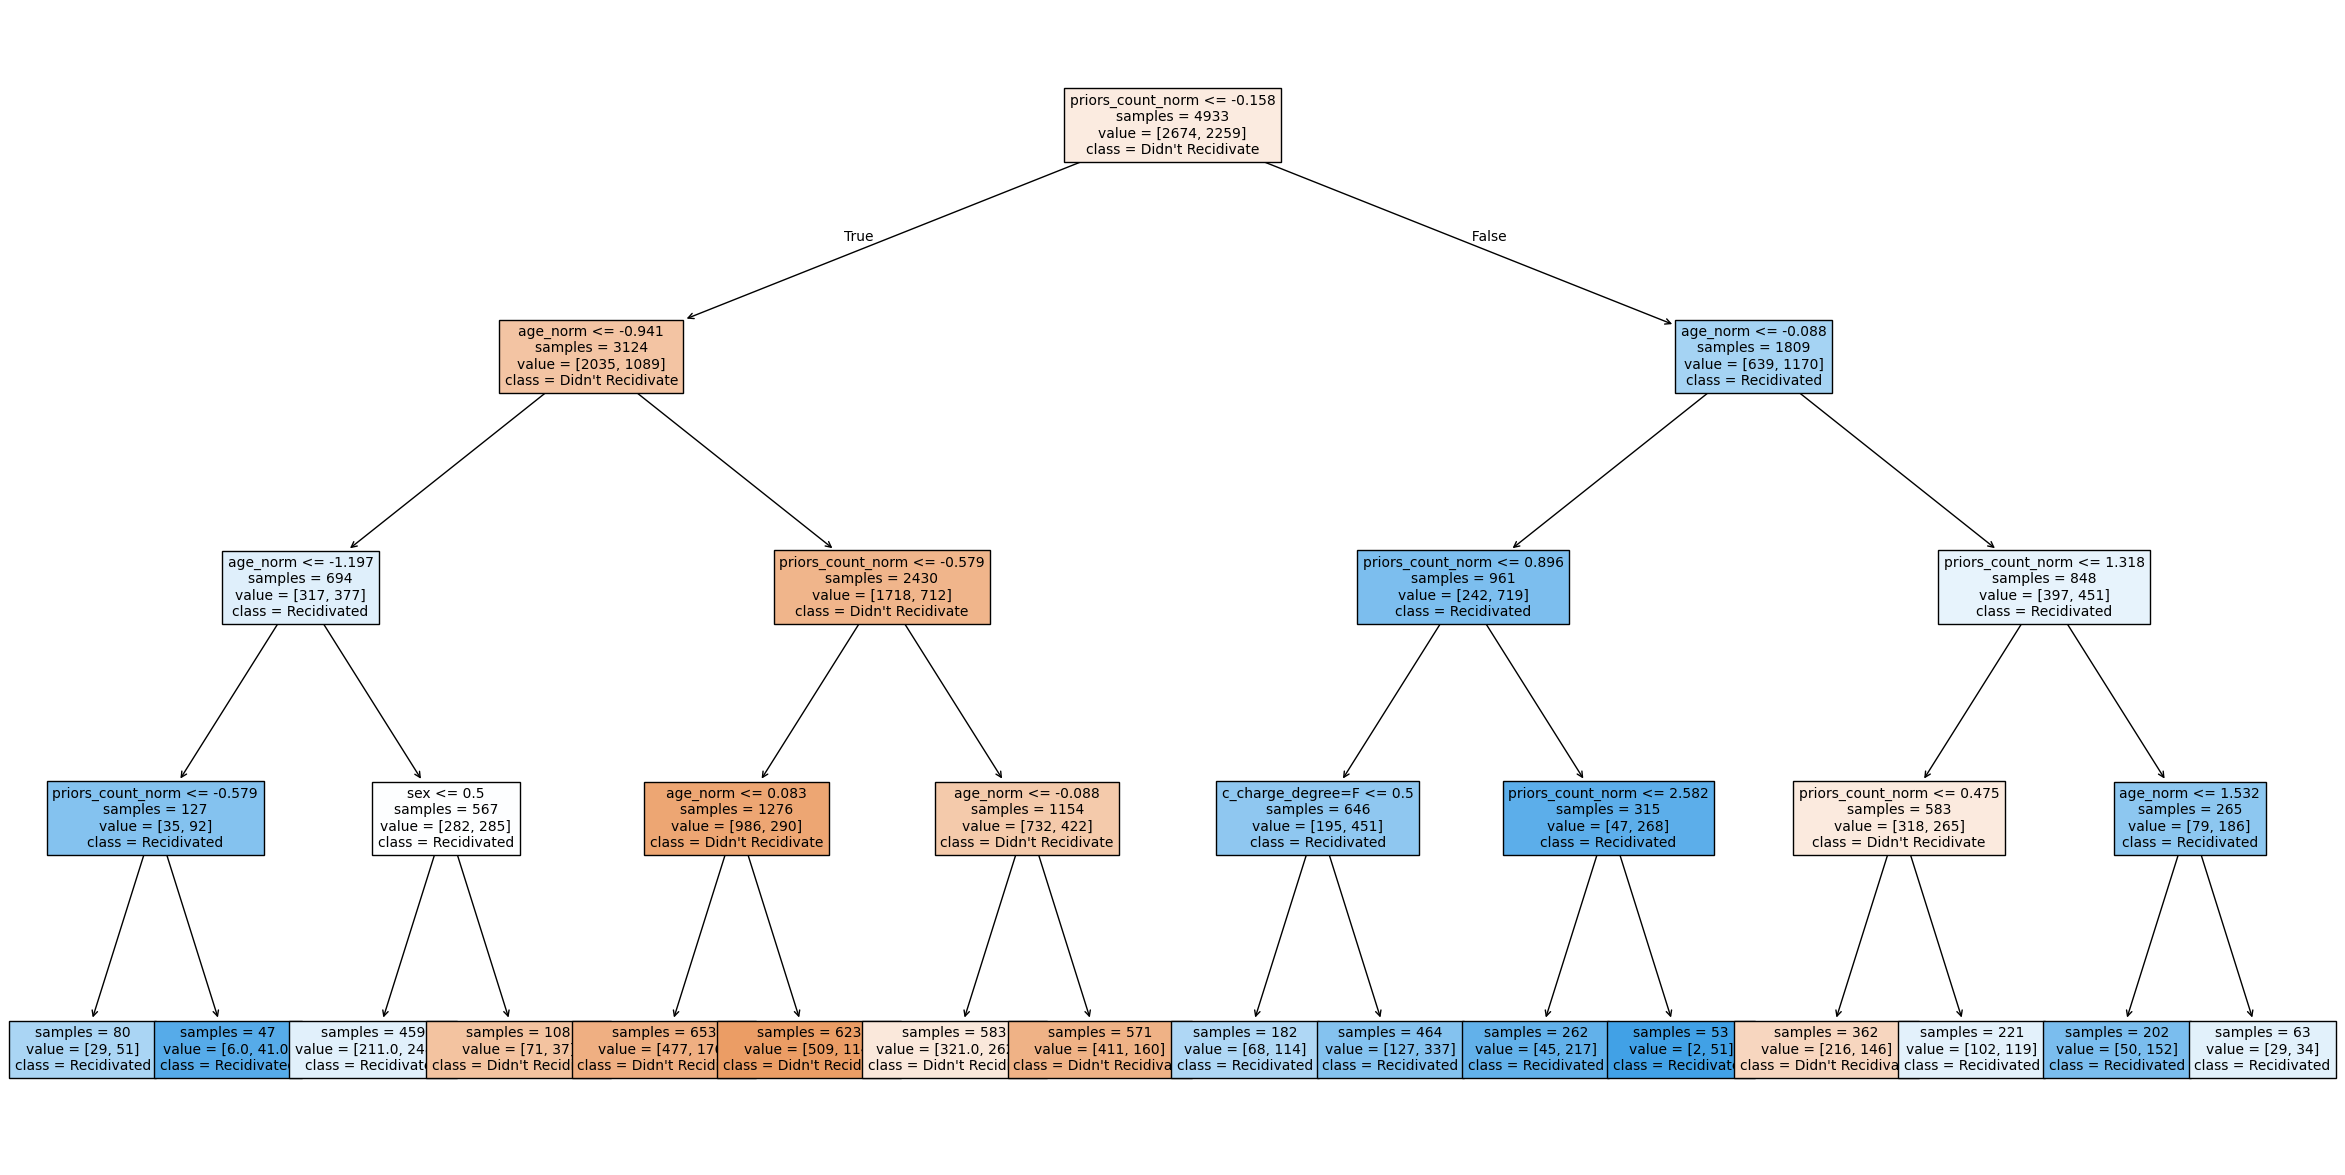

In [100]:
from sklearn.tree import plot_tree

plt.figure(figsize=(30,15))
plot_tree(MODEL_2.model, fontsize=10, impurity=False, class_names=LABEL_NAMES, feature_names=INDEP_VARS_TRANSFORMED, filled=True)
plt.show()

### Feature Importance for Logistic Regression

,Feature,Importance,Importance_abs
2,race=white,0.002864,0.002864
4,juv_misd_count_norm,0.023555,0.023555
9,age_cat=Less than 25,-0.042406,0.042406
3,juv_fel_count_norm,0.042730,0.042730
10,c_charge_degree=F,0.072935,0.072935
5,juv_other_count_norm,0.096058,0.096058
11,c_charge_degree=M,-0.105941,0.105941
7,age_cat=25 - 45,-0.201789,0.201789
8,age_cat=Greater than 45,0.211190,0.211190
0,sex=male,-0.303049,0.303049


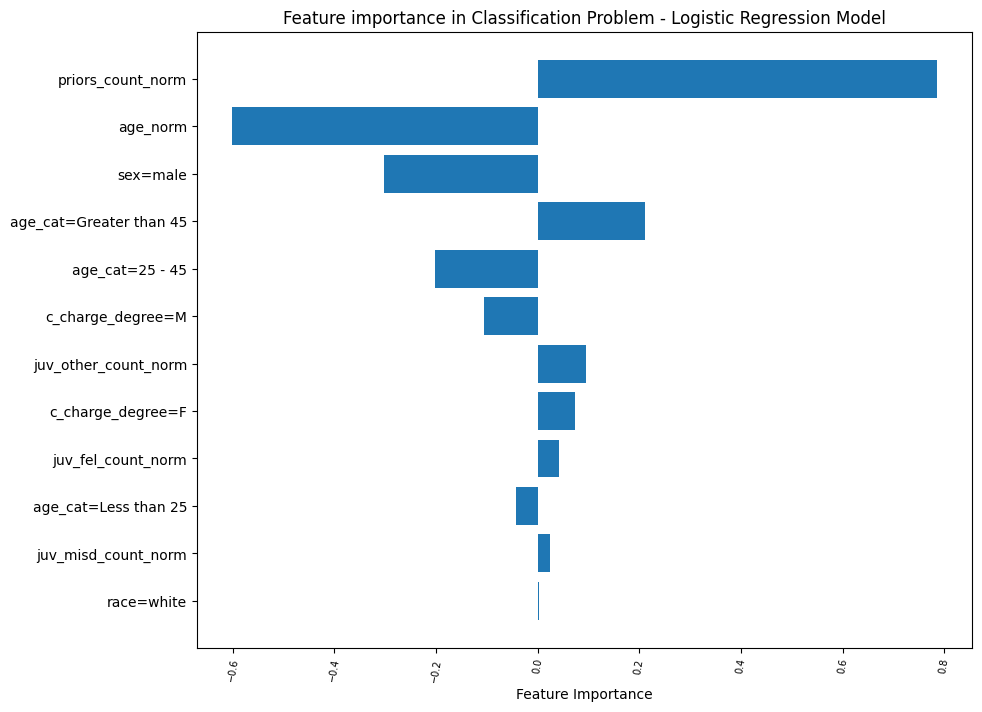

In [101]:
col_replacements = {'sex':'sex=male', 'race':'race=white'}
feature_importance = pd.DataFrame({
    'Feature': [ col_replacements.get(colname, colname) for colname in INDEP_VARS_TRANSFORMED] ,
    'Importance': MODEL_1.model.coef_[0]
})
feature_importance['Importance_abs'] = feature_importance['Importance'].apply(lambda x: -1*x if x<0 else x)
feature_importance.sort_values(by='Importance_abs', inplace=True, ascending=True)

plt.figure(figsize=(10,8))
subset = feature_importance.tail(20)
plt.barh(subset['Feature'], subset['Importance'])
plt.xticks(rotation=80, fontsize=7)
plt.xlabel('Feature Importance')
plt.title("Feature importance in Classification Problem - Logistic Regression Model")
subset


### print feature importance for logistic regression

In [102]:
feature_importance.sort_values(by='Importance_abs', inplace=True, ascending=False)
feature_importance.head(30)

,Feature,Importance,Importance_abs
6,priors_count_norm,0.785563,0.785563
1,age_norm,-0.600491,0.600491
0,sex=male,-0.303049,0.303049
8,age_cat=Greater than 45,0.211190,0.211190
7,age_cat=25 - 45,-0.201789,0.201789
11,c_charge_degree=M,-0.105941,0.105941
5,juv_other_count_norm,0.096058,0.096058
10,c_charge_degree=F,0.072935,0.072935
3,juv_fel_count_norm,0.042730,0.042730
9,age_cat=Less than 25,-0.042406,0.042406
